# Causal Inference Tutorial with Python

This notebook demonstrates causal inference techniques using the LaLonde dataset. We'll cover:

1. Data Loading and Exploration
2. Naive Difference-in-Means
3. Propensity Score Matching (PSM)
4. Double Machine Learning (DML) with EconML



# Causal Inference Tutorial with Python using the LaLonde Dataset

This tutorial explores fundamental concepts and intuitions in causal inference using the well-known LaLonde dataset, as demonstrated in the provided Jupyter Notebook. The goal of causal inference is to estimate the effect of a treatment or intervention (like a job training program) on an outcome, while accounting for factors that might bias the results.

## The LaLonde Dataset

The LaLonde dataset is frequently used in causal inference to study the impact of a job training program, the National Supported Work (NSW) Demonstration, on participants' earnings. It includes both an experimental (randomized) control group and non-experimental comparison groups. The dataset contains the following key variables:

* **treat**: Indicates if an individual participated in the program (1) or not (0).
* **age**: Age in years.
* **educ**: Years of education.
* **black**: Indicator for Black individuals (1 if Black, 0 otherwise).
* **hispan**: Indicator for Hispanic individuals (1 if Hispanic, 0 otherwise).
* **married**: Indicator for married individuals (1 if married, 0 otherwise).
* **nodegree**: Indicator for individuals without a high school degree (1 if no degree, 0 otherwise).
* **re74**: Real earnings in 1974.
* **re75**: Real earnings in 1975.
* **re78**: Real earnings in 1978 (the outcome variable).

The dataset contains 614 observations, with 185 individuals in the treatment group and 429 in the control group.

## Naive Difference-in-Means

A simple, but often biased, way to estimate the causal effect is to calculate the naive difference in means of the outcome variable between the treated and control groups.

**Intuition:** If the treatment caused the outcome, the average outcome for the treated group should differ from the average outcome for the control group.

**Calculation:**
$$ATE_{naive} = \text{Mean}(Y | \text{treat}=1) - \text{Mean}(Y | \text{treat}=0)$$

In the LaLonde dataset, the naive ATE was calculated as -635.03.

**Interpretation and Caution:** A negative ATE here suggests that treated individuals earned, on average, \$635 less than control individuals in 1978. However, this is a naive estimate because it doesn't account for potential differences between the treated and control groups *before* the treatment was applied. If individuals in the treatment group were already systematically different (e.g., poorer, less educated) than the control group, this difference in baseline characteristics, rather than the treatment itself, could be the reason for the observed difference in earnings. This highlights the problem of confounding.

## Propensity Score Matching (PSM)

Propensity Score Matching is a technique used to reduce bias due to confounding by creating a comparison group that is similar to the treatment group based on observable characteristics.

**Intuition:** Instead of directly comparing the treated and control groups, we first estimate the probability of an individual receiving the treatment given their observed characteristics (the propensity score). Then, for each treated individual, we find a control individual with a similar propensity score to serve as a match. By matching individuals on their propensity scores, we aim to create treated and matched-control groups that are more comparable on average in terms of their observable baseline characteristics.

**Steps:**

1.  **Estimate Propensity Scores:** Use a model (like logistic regression) to predict the probability of receiving treatment based on pre-treatment covariates (age, education, race, marital status, degree status, and prior earnings).
2.  **Match Treated and Control Units:** For each treated individual, find one or more control individuals with similar propensity scores. Nearest neighbor matching is a common method.
3.  **Compute ATE:** Calculate the difference in the outcome variable between the treated individuals and their matched control individuals.


## Double Machine Learning (DML)

Double Machine Learning is a more advanced technique that uses machine learning models to estimate the causal effect while being robust to the specification of these models.

**Intuition:** DML works by 'deconfounding' the relationship between the treatment and the outcome. It involves two main steps, each typically using a machine learning model:
1.  Model the outcome based on the confounding variables.
2.  Model the treatment based on the confounding variables.
By residualizing the outcome and treatment with respect to the confounders, DML can estimate the causal effect more reliably, even if the machine learning models are not perfectly specified.

**Steps:**

1.  **Prepare Data:** Define the outcome variable (Y), the treatment variable (T), and the confounding variables (X).
2.  **Define DML Estimator:** Use a DML model (like `LinearDML` from the EconML library) and specify the machine learning models to use for modeling the outcome and treatment (e.g., RandomForestRegressor and RandomForestClassifier).
3.  **Fit and Estimate ATE:** Fit the DML model to the data and estimate the Average Treatment Effect (ATE).

The provided notebook includes code to perform DML, although the output was not available.

**Interpretation:** The ATE estimated by DML provides another, often more robust, estimate of the causal effect of the treatment on the outcome, further attempting to reduce bias.

## Interpretation Summary

* **Naive ATE** may be biased due to confounders.
* **PSM ATE** adjusts for observable confounders.
* **DML ATE** further reduces bias by using machine learning models for nuisance estimation.

Understanding these different approaches and their underlying assumptions is crucial for drawing valid causal conclusions from observational data.

The Lalonde dataset is a well-known dataset in economics and causal inference research, often used to study the effects of a job training program on earnings. It comes from Robert LaLonde's 1986 paper "Evaluating the Econometric Evaluations of Training Programs with Experimental Data."

| Aspect        | Details                                                                                                                                  |
|---------------|------------------------------------------------------------------------------------------------------------------------------------------|
| Purpose       | To evaluate the impact of a job training program (the National Supported Work (NSW) Demonstration) on participants' earnings.              |
| Type          | Causal inference, treatment effect evaluation.                                                                                         |
| Key Variables | treat (treatment indicator), re78 (real earnings in 1978), age, education, black, hispanic, married, nodegree, re74, re75 (past earnings). |
| Sample        | Individuals either randomly assigned to receive job training (treatment group) or not (control group).                                   |
| Special Feature| Includes both an experimental (randomized) control group and non-experimental comparison groups from other surveys like CPS (Current Population Survey). |

## Counfoundng 
Confounding occurs in causal inference when a variable influences both the treatment assignment and the outcome. This makes it difficult to determine if the observed effect on the outcome is due to the treatment or the confounding variable.

In the context of the LaLonde dataset and the job training program, variables such as individuals' prior earnings (re74, re75), age, and education level are potential confounders.

Here's why:

Influence on Treatment: Individuals with lower prior earnings, less education, or who are younger might be more likely to enroll in a job training program.
Influence on Outcome: These same characteristics (prior low earnings, less education, younger age) can also directly affect an individual's future earnings (re78), regardless of whether they received the training.
Because these variables affect both the likelihood of receiving the job training (treatment) and the subsequent earnings (outcome), they confound the relationship between the treatment and the outcome.

This is why the naive difference-in-means calculation is biased. It simply compares the average earnings of the treated and control groups without accounting for these pre-existing differences. The observed difference in earnings could be partly or entirely due to the fact that the groups were not comparable at the start. Techniques like Propensity Score Matching and Double Machine Learning are used precisely to try and account for these confounding variables and obtain a less biased estimate of the treatment's true causal effect.

## 1. Setup
Install and import required packages.

In [15]:
# !pip install econml


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler


## 2. Load Dataset
We'll use the LaLonde dataset from GitHub.

In [2]:
# LaLonde dataset URL
url = "https://raw.githubusercontent.com/robjellis/lalonde/refs/heads/master/lalonde_data.csv"

# Load and preview
df = pd.read_csv(url, index_col=0)
df = df.reset_index()
df.head()


,ID,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## 3. Exploratory Data Analysis

In [3]:
# Summary statistics
df.describe()




,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
# Treatment group sizes
df['treat'].value_counts()

treat
0    429
1    185
Name: count, dtype: int64

## 4. Naive Difference-in-Means

In [5]:
# Simple ATE estimate without adjustment
ate_naive = df[df['treat'] == 1]['re78'].mean() - df[df['treat'] == 0]['re78'].mean()
print(f"Naive ATE: {ate_naive:.2f}")


Naive ATE: -635.03


On average, treated individuals earned $635 less than control individuals in 1978.

A negative ATE means treated people did worse than control.

Naively, it looks like treatment reduced income by $635.

BUT WAIT — this is a naive estimate ❗
It ignores important facts like:

Maybe people who got treated were poorer to begin with.

Maybe they were less educated or unemployed.

Maybe they faced different labor market conditions.

In short:

Treated vs control groups may not be comparable before treatment.

This is exactly why we use matching, regression adjustment, DML, etc. — to fix the bias and get closer to the true causal effect.

## What is an Observational Study?

An **observational study** is when we observe and analyze data without controlling how individuals are assigned to treatments or groups. We simply record what naturally happens. We do *not* randomly assign people to treatment or control.

### More Intuitively

| Feature                | Randomized Experiment (RCT)         | Observational Study                      |
| :--------------------- | :---------------------------------- | :--------------------------------------- |
| How groups are formed  | We randomly assign treatment/control | People choose or naturally differ        |
| Example                | Randomly giving half the people a drug | Looking at people who chose a drug       |
| Researcher's control | Full (can design the assignment)    | None (just observe what happened)        |

### Examples of Observational Studies

* Studying whether people who exercise regularly have lower rates of heart disease.
* Studying the effect of smoking on lung cancer by comparing smokers vs non-smokers.
* Analyzing the impact of a job training program where people volunteered for training (like the lalonde dataset).

In all these examples, the participants self-select or naturally fall into groups. Researchers do not intervene.

### Why is this Important?

Because without random assignment, the two groups may differ in important ways even before treatment. Those differences (called **confounders**) can bias the estimate of the treatment effect.

To address this, we use techniques like:

* Propensity Score Matching (PSM)
* Difference-in-Differences (DiD)
* Instrumental Variables (IV)
* Inverse Probability Weighting (IPW)
* DML ( mainly designed for observational studies, not RCTs)

**Goal:** To simulate what would have happened if we could have done a randomized experiment.

### Quick Summary

**Observational study = Nature assigns treatment, not the researcher.**

## 5. Propensity Score Matching (PSM)
1. Estimate propensity scores via logistic regression
2. Match treated and control units
3. Compute ATE

> basically matching based on odds of receieving the treatment

# Propensity Score Matching (PSM) Steps

- Propensity Score Matching is a statistical technique used to estimate the effect of a treatment, policy, or other intervention by accounting for the covariates that predict receiving the treatment. The goal is to create a treated and control group that are similar in terms of observed characteristics, thereby reducing confounding and allowing for a more accurate estimate of the treatment effect


-  The propensity score is the probability of receiving the treatment (being in the 'treat=1' group) given the observed pre-treatment characteristics (the features in X). We use a logistic regression model because it naturally predicts probabilities (values between 0 and 1). By estimating this probability for every individual (both treated and control), we summarize all their measured pre-treatment differences into a single number – the propensity score. The idea is that individuals with similar propensity scores are comparable in terms of their observed covariates, regardless of whether they actually received the treatment.


- For each individual in the treated group, we find the individual in the control group who has the closest propensity score. This is the "nearest neighbor" matching approach. We fit the NearestNeighbors model on the control group because we are searching for control individuals to match to the treated individuals. kneighbors then performs this search. The indices tell us which control row corresponds to the nearest neighbor for each treated row. We then use these indices to select those specific control individuals to form our matched_control group. The goal is that after this step, the matched_control group should look very similar to the treated group in terms of the distribution of their propensity scores (and, hopefully, the underlying covariates they represent).



In [18]:

# 🧹 1. Preprocessing: Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']])

# 🎯 2. Estimate Propensity Scores
ps_model = LogisticRegression(max_iter=1000, solver='lbfgs')
ps_model.fit(X, df['treat'])
df['propensity_score'] = ps_model.predict_proba(X)[:, 1]

# 👫 3. Separate Treated and Control Groups
treated = df[df['treat'] == 1].copy()
control = df[df['treat'] == 0].copy()

# 🔎 4. Nearest Neighbor Matching based on Propensity Score
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])  # Fit on control group's propensity scores
distances, indices = nn.kneighbors(treated[['propensity_score']])  # Find nearest neighbor for each treated
matched_control = control.iloc[indices.flatten()]  # Fetch matched controls

# 🔗 5. Combine matched treated and control units
matched = pd.concat([treated, matched_control])

# 📈 6. Estimate PSM ATE (Average Treatment Effect)
ate_psm = matched[matched['treat'] == 1]['re78'].mean() - matched[matched['treat'] == 0]['re78'].mean()
print(f"PSM ATE: {ate_psm:.2f}")

PSM ATE: 1227.24


In [20]:
matched.treat.value_counts()

treat
1    185
0    185
Name: count, dtype: int64

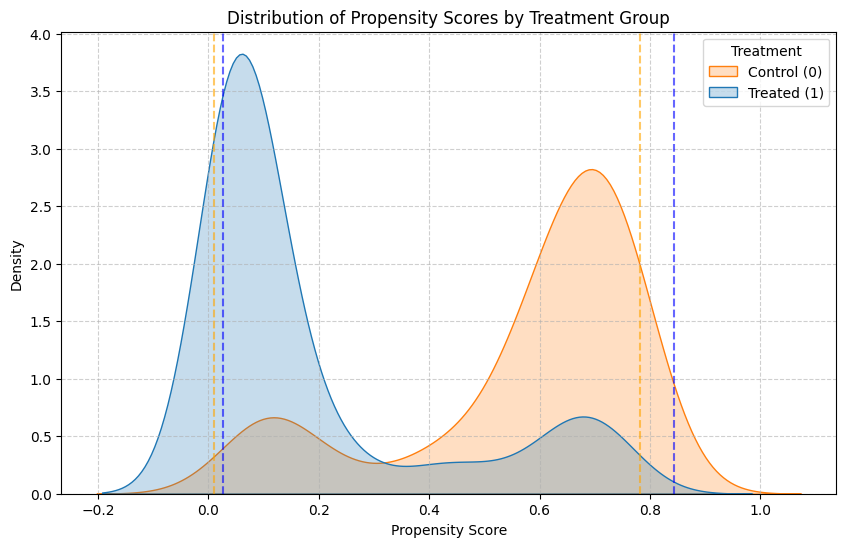

In [12]:

plt.figure(figsize=(10, 6))

# Create density plots for propensity scores, separated by the 'treat' column
sns.kdeplot(data=df, x='propensity_score', hue='treat', fill=True, common_norm=False)

# Add titles and labels
plt.title('Distribution of Propensity Scores by Treatment Group')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Treatment', labels=['Control (0)', 'Treated (1)']) # Custom legend labels if needed

# Add vertical lines to indicate min/max for each group for clearer overlap check
min_ps_treated = df[df['treat'] == 1]['propensity_score'].min()
max_ps_treated = df[df['treat'] == 1]['propensity_score'].max()
min_ps_control = df[df['treat'] == 0]['propensity_score'].min()
max_ps_control = df[df['treat'] == 0]['propensity_score'].max()

# Plot lines for treated group bounds
plt.axvline(min_ps_treated, color='blue', linestyle='--', label='Treated PS Range', alpha=0.6)
plt.axvline(max_ps_treated, color='blue', linestyle='--', alpha=0.6)

# Plot lines for control group bounds
plt.axvline(min_ps_control, color='orange', linestyle='--', label='Control PS Range', alpha=0.6)
plt.axvline(max_ps_control, color='orange', linestyle='--', alpha=0.6)

# Refine legend to include the range lines
handles, labels = plt.gca().get_legend_handles_labels()
# The kdeplot legend is added first, then the axvline labels. Combine them.
# You might need to adjust the order if you add more things to the legend.
order = [2, 3, 0, 1] # Adjust order to maybe put range lines last or first
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Legend')
# A simpler approach: manually define legend or skip ranges if it clutters
# plt.legend(title='Treatment', labels=['Control (0)', 'Treated (1)']) # Keep simple kde legend

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 6. Double Machine Learning (DML)
Using EconML's `LinearDML` for a more robust estimate.

Got it — here’s the **full explanation of DML intuition**, rewritten **cleanly without emojis**, ready to paste into VS Code or Jupyter:

---

# Double Machine Learning (DML) Intuition

---

## Problem Setup

In observational studies, both the **outcome** (Y) and the **treatment assignment** (T) depend on observed covariates (X).

- People are **not assigned treatment randomly**.
- Simply running a regression like `Y ~ T` would **give biased estimates**, because **T is correlated with X**, and **X affects Y**.

We need to adjust carefully for X to isolate the true effect of T on Y.

---

## Traditional Approach

A common method is to run a linear regression:
```python
Y ~ T + X
```
This tries to control for X.

**Problem**:  
Linear models can miss complex **nonlinearities**, **interactions**, and **hidden patterns** in the data.

---

## Double Machine Learning (DML) Approach

**Key idea**: Use machine learning to flexibly adjust for X, then estimate the causal effect.

Steps:

1. **First Stage**:  
   - Predict Y using X: get predicted Y-hat.
   - Predict T using X: get predicted T-hat.

2. **Second Stage**:  
   - Calculate residuals:
     - Residual for Y = Y - predicted Y-hat
     - Residual for T = T - predicted T-hat
   - Regress the residuals of Y on the residuals of T.

This approach "partials out" the effect of X from both Y and T, and estimates the effect of T on Y more cleanly.

---
Intuition
✅ Step 1: Predict how much of 
𝑌
Y and 
𝑇
T can be explained by 
𝑋
X.

✅ Step 2: Remove that explained part → focus only on what's left (the residuals).

✅ Step 3: Regress the leftover part of Y on the leftover part of T → this gives you the causal effect of 
𝑇
T on 
𝑌
Y.
## Why Is It Called "Double" Machine Learning?

Because machine learning is used **twice**:

- Once to model Y as a function of X.
- Once to model T as a function of X.

Both steps help in controlling for confounding from X.

---

## What Happens in Your Code

```python
# Prepare the data
X = df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]
T = df['treat']
Y = df['re78']

# Define the DML estimator
dml_est = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)

# Fit the DML model
dml_est.fit(Y, T, X=X)

# Estimate ATE
ate_dml = dml_est.ate(X=X)
print(f"DML ATE: {ate_dml:.2f}")
```

What this code does:

- Predicts earnings (`re78`) using features.
- Predicts whether someone was treated based on features.
- Calculates the **Average Treatment Effect** (ATE) after adjusting for the predicted parts.

---

## Core Intuition

| Concept | Meaning |
|:---|:---|
| Partial out | Remove the influence of X from both T and Y |
| Machine learning models | Capture complex relationships (not restricted to linear) |
| Residual-on-residual regression | Focus only on the variation in T and Y not explained by X |

---

## Simple Summary

Double Machine Learning carefully removes the parts of treatment assignment and outcomes that are explained by covariates (X), using machine learning, and then estimates the treatment effect only from the part that is **not confounded**.

---

## Why Use DML?

- Can handle a **large number of covariates**.
- Can model **complex relationships** flexibly.
- Reduces **overfitting bias** by using sample splitting and cross-fitting internally.
- Works well for **both low-dimensional and high-dimensional** X.

---
Estimating the ATE:
The coefficient 
𝛽
β from this regression is the average treatment effect (ATE). In other words, 
𝛽
β represents the estimated causal effect of the treatment on the outcome, after adjusting for the confounding factors 
𝑋
X.


In [22]:
# Prepare data
X = df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]
T = df['treat']
Y = df['re78']

# Define DML estimator
dml_est = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)

# Fit and estimate ATE
dml_est.fit(Y, T, X=X)
ate_dml = dml_est.ate(X=X)
print(f"DML ATE: {ate_dml:.2f}")


DML ATE: 1100.23


## 7. Interpretation
- **Naive ATE** may be biased due to confounders.
- **PSM ATE** adjusts for observable confounders.
- **DML ATE** further reduces bias by using machine learning models for nuisance estimation.



## Difference in diffrence

DiD compares how much the outcome changed over time for the treated group relative to the control group.

It's like:
"How much more did the treated group's earnings grow compared to the control group?"

✅ It removes biases from time trends that affect both groups.

for lalonde:

treat = 1 if participated in job training, 0 if not.

re78 = Earnings after program (in 1978).

re74 or re75 = Earnings before program (in 1974 or 1975).

We'll use 1975 (re75) as pre-treatment and 1978 (re78) as post-treatment.

In Difference-in-Differences (DiD), we want to compare how much the treated group's earnings changed over time versus how much the control group's earnings changed over time.
The interaction term treat:year captures exactly that extra change for the treated group above and beyond any general trend over time that affects everyone.

By including the interaction, we are isolating the causal effect of the treatment, removing any "normal" changes that would have happened anyway.
The goal is to estimate:
➡️ (Treated group's before-after change) - (Control group's before-after change) = True causal effect.

Code Explanation:
df.assign(year=0, earnings=df['re75']): This creates a temporary DataFrame based on your original df. It adds a new column year set to 0 (representing the pre-treatment period, using 1975 earnings) and a new column earnings containing the values from re75.
df.assign(year=1, earnings=df['re78']): This creates another temporary DataFrame, adding year set to 1 (representing the post-treatment period, using 1978 earnings) and earnings from re78.
pd.concat([...]): This stacks the two temporary DataFrames on top of each other. Now, each individual from the original df appears twice in df_long: once for the pre-treatment year (year=0, earnings=re75) and once for the post-treatment year (year=1, earnings=re78). The treat variable remains the same for each individual across both rows.

The DiD estimate can be obtained as the coefficient of the interaction term in a standard Ordinary Least Squares (OLS) regression. The model captures the average earnings at baseline, the average difference between treated and control groups at baseline, the average change over time for the control group, and crucially, the additional change over time experienced by the treated group compared to the control group.

In [7]:
# 📚 Import needed libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

# 👩‍🔧 1. Create 'time' indicator
# 0 for pre-treatment (1975), 1 for post-treatment (1978)
df_long = pd.concat([
    df.assign(year=0, earnings=df['re75']),
    df.assign(year=1, earnings=df['re78'])
])

# 👨‍🔬 2. Build DiD model
# We regress earnings on treat, year, and treat*year interaction
model = smf.ols('earnings ~ treat + year + treat:year', data=df_long).fit()

# 📈 3. Print results
print(model.summary())

# 🎯 4. DiD Estimate (effect of treatment)
did_estimate = model.params['treat:year']
print(f"\nDiD Estimate (Causal Effect of Training on Earnings): {did_estimate:.2f}")


                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     66.99
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           4.14e-40
Time:                        11:07:51   Log-Likelihood:                -12375.
No. Observations:                1228   AIC:                         2.476e+04
Df Residuals:                    1224   BIC:                         2.478e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2466.4844    278.425      8.859      0.0


**Dummy Variable Regression Intuition:** In regression analysis, dummy variables (like 'treat' and 'year' here) are used to represent categorical information within a numerical model. Each dummy variable typically takes a value of 0 or 1, indicating the absence or presence of a particular characteristic or group. By including these variables, the regression model can estimate the average outcome for each category relative to a chosen baseline or reference category **(often the group where all relevant dummy variables are set to 0)**. The coefficients on the dummy variables then quantify the estimated difference in the outcome associated with belonging to that specific category, holding other factors constant. In this context, 'treat' captures the difference between treated and control groups, and 'year' captures the difference between time periods, allowing us to isolate and estimate the effects of being in the treated group in the later time period through the interaction term.

**Intercept (2466.48):** This is the estimated average earnings for the control group (treat=0) in the pre-treatment period (year=0).

**treat (-934.43):** This is the estimated average difference in earnings between the treated group and the control group in the pre-treatment period (year=0). It suggests the treated group started with earnings about $934 lower than the control group, though this difference is not statistically significant at the conventional 0.05 level (p-value = 0.066).

**year (4517.69):** This is the estimated average change in earnings from the pre-treatment period (year=0) to the post-treatment period (year=1) for the control group (treat=0). It suggests the control group's earnings increased by about $4518 over this period, which is highly statistically significant (p-value = 0.000). This captures general trends in earnings over time that would have affected both groups.

**treat:year (299.40):** This is your Difference-in-Difference estimate. It represents the estimated additional change in earnings from the pre-treatment to the post-treatment period for the treated group, compared to the control group.The value 299.40 suggests that the job training program is associated with an increase of approximately $299.40 in earnings in 1978, relative to what their earnings would have been had they followed the same trend as the control group.

**Statistical Significance:** Look at the p-value for treat:year, which is 0.676. This is much greater than the conventional significance level of 0.05. This means that the estimated effect of $299.40 is not statistically significant. We cannot confidently conclude that the training program had a causal effect on earnings based on this DiD analysis at standard significance levels.

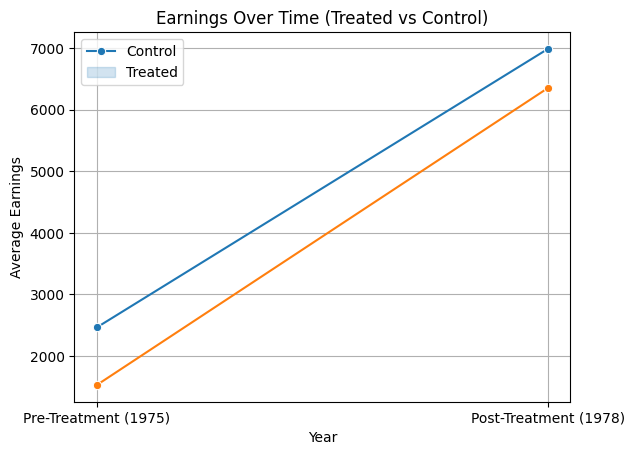

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Plot average earnings
avg_earnings = df_long.groupby(['treat', 'year'])['earnings'].mean().reset_index()

sns.lineplot(x='year', y='earnings', hue='treat', data=avg_earnings, marker='o')
plt.title('Earnings Over Time (Treated vs Control)')
plt.xticks([0, 1], ['Pre-Treatment (1975)', 'Post-Treatment (1978)'])
plt.xlabel('Year')
plt.ylabel('Average Earnings')
plt.legend(labels=['Control', 'Treated'])
plt.grid(True)
plt.show()
